In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import rasterio as rio
%matplotlib inline

In [6]:
for year in range(2016, 2020):
    deets = pd.read_csv("Data/Details_"+str(year)+".csv")
    locs = pd.read_csv("Data/Locations_"+str(year)+".csv")
    fatalities = pd.read_csv("Data/Fatalities_"+str(year)+".csv")
    print(year, deets.shape, locs.shape, fatalities.shape)

(2016, (56003, 51), (41619, 11), (669, 11))
(2017, (57024, 51), (42310, 11), (776, 11))
(2018, (62351, 51), (47876, 11), (799, 11))
(2019, (46621, 51), (46486, 11), (400, 11))


# Initial Data Wrangling and Exploration

In [3]:
all_files = ["Data/Details_"+str(year)+".csv" for year in range(2016, 2020)]
df = pd.concat((pd.read_csv(f) for f in all_files))
df.columns

Index([u'BEGIN_YEARMONTH', u'BEGIN_DAY', u'BEGIN_TIME', u'END_YEARMONTH',
       u'END_DAY', u'END_TIME', u'EPISODE_ID', u'EVENT_ID', u'STATE',
       u'STATE_FIPS', u'YEAR', u'MONTH_NAME', u'EVENT_TYPE', u'CZ_TYPE',
       u'CZ_FIPS', u'CZ_NAME', u'WFO', u'BEGIN_DATE_TIME', u'CZ_TIMEZONE',
       u'END_DATE_TIME', u'INJURIES_DIRECT', u'INJURIES_INDIRECT',
       u'DEATHS_DIRECT', u'DEATHS_INDIRECT', u'DAMAGE_PROPERTY',
       u'DAMAGE_CROPS', u'SOURCE', u'MAGNITUDE', u'MAGNITUDE_TYPE',
       u'FLOOD_CAUSE', u'CATEGORY', u'TOR_F_SCALE', u'TOR_LENGTH',
       u'TOR_WIDTH', u'TOR_OTHER_WFO', u'TOR_OTHER_CZ_STATE',
       u'TOR_OTHER_CZ_FIPS', u'TOR_OTHER_CZ_NAME', u'BEGIN_RANGE',
       u'BEGIN_AZIMUTH', u'BEGIN_LOCATION', u'END_RANGE', u'END_AZIMUTH',
       u'END_LOCATION', u'BEGIN_LAT', u'BEGIN_LON', u'END_LAT', u'END_LON',
       u'EPISODE_NARRATIVE', u'EVENT_NARRATIVE', u'DATA_SOURCE'],
      dtype='object')

In [85]:
casualty_cols = ['INJURIES_DIRECT','INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT']
damage_cols = ['DAMAGE_PROPERTY', 'DAMAGE_CROPS']

df['CASUALTIES'] = df[casualty_cols].sum(axis=1)
df['DAMAGES'] = df[damage_cols].sum(axis=1) #need to parse strings, and convert to numeric!
df['DURATION'] = (pd.to_datetime(df['END_DATE_TIME']).subtract(pd.to_datetime(df['BEGIN_DATE_TIME']))).astype('timedelta64[h]')

In [87]:
pd.unique(df['DURATION'])

array([  0.,  27.,  25.,   8.,  10.,   3.,   7.,   4.,   6.,   2., 743.,
         5.,  16.,  14.,   1.,  35.,  11.,  32.,  12.,   9.,  20.,  31.,
        55.,  19.,  15., 719.,  33.,  23.,  41.,  17., 214.,  30.,  36.,
        24.,  18.,  48.,  51.,  60.,  74.,  29.,  21.,  84., 600.,  58.,
        46.,  40.,  91.,  37.,  38.,  26.,  13.,  28., 401.,  22.,  43.,
        95., 123., 113.,  76.,  62., 127., 386.,  93.,  34.,  45.,  96.,
        72.,  70., 111.,  68., 120., 221.,  47.,  71., 720., 497., 130.,
       116.,  97., 110.,  92.,  80.,  88.,  59.,  42.,  52., 208., 383.,
        77.,  39.,  49.,  99.,  44., 409., 240., 367., 323., 314., 185.,
       276.,  64.,  86., 388., 437.,  89.,  82., 381., 205., 144., 181.,
       245., 327., 377.,  67., 139.,  53., 695.,  57., 171., 268., 108.,
        54., 211., 344., 360., 161., 317., 146.,  66., 151., 182., 178.,
       166., 104., 134., 131., 261., 125., 180., 101., 107., 102., 100.,
        50., 168., 124.,  75.,  61., 307., 390., 47

In [90]:
casualty_cols = ['INJURIES_DIRECT','INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT']
damage_cols = ['DAMAGE_PROPERTY', 'DAMAGE_CROPS']
dt_factors = ['YEAR','MONTH_NAME','STATE_FIPS']
excluded_factors = ['CATEGORY','WFO']+dt_factors+casualty_cols+damage_cols
df.drop(excluded_factors, axis=1, inplace=True)
df.drop(df.filter(regex='BEGIN|END|CZ|TOR\_OTHER'), axis=1, inplace=True)

In [32]:
print(list(df))#['EVENT_TYPE'].unique())

['EPISODE_ID', 'EVENT_ID', 'STATE', 'EVENT_TYPE', 'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE', 'CASUALTIES', 'DAMAGES', 'DURATION']


## Initial Models

In [33]:
real_df = df[['MAGNITUDE','TOR_LENGTH','TOR_WIDTH','DURATION','CASUALTIES']]
real_df.fillna(0, inplace=True)
full_x = real_df[['MAGNITUDE','TOR_LENGTH','TOR_WIDTH','DURATION']]
full_y = real_df['CASUALTIES']
x_train, x_test, y_train, y_test = train_test_split(full_x, full_y, train_size=0.8, random_state=4741)

In [34]:
print(df.corr()['CASUALTIES'])
print(df['CASUALTIES'].shape,real_df['CASUALTIES'][real_df['CASUALTIES']>0].shape)

EPISODE_ID   -0.001220
EVENT_ID     -0.001332
MAGNITUDE     0.020456
TOR_LENGTH    0.215606
TOR_WIDTH     0.163094
CASUALTIES    1.000000
DAMAGES            NaN
DURATION      0.003238
Name: CASUALTIES, dtype: float64
((221999,), (2796,))


In [35]:
model = LinearRegression()
model.fit(x_train,y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_test, y_test))

('Training accuracy: ', 0.0072140653981119796)
('Cross validation accuracy: ', 0.006259376605171063)


In [36]:
cat_df = df[['EVENT_TYPE','FLOOD_CAUSE','MAGNITUDE','TOR_LENGTH','TOR_WIDTH','DURATION','CASUALTIES']]
cat_df.fillna(0, inplace=True)
full_x = cat_df[['EVENT_TYPE','FLOOD_CAUSE','MAGNITUDE','TOR_LENGTH','TOR_WIDTH','DURATION']].pipe(
    pd.get_dummies,
    prefix_sep='_', 
    drop_first=True
)
full_y = cat_df['CASUALTIES']

In [37]:
x_train, x_test, y_train, y_test = train_test_split(full_x, full_y, train_size=0.8, random_state=4741)

In [38]:
model = DecisionTreeRegressor(max_depth=3)
model.fit(x_train,y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_test, y_test))

('Training accuracy: ', 0.03375687366252278)
('Cross validation accuracy: ', -0.026621803870732652)


# Additional Data Exploration

In [39]:
df['EVENT_TYPE'][df['EVENT_TYPE'].str.match(".*Flood$")] = "Flood"
df['EVENT_TYPE'][df['EVENT_TYPE'].str.match(".*Wind$")] = "Wind"
df['EVENT_TYPE'][df['EVENT_TYPE'].str.contains(".*Hail$")] = "Hail"
df.groupby(['EVENT_TYPE']).agg({'CASUALTIES':np.sum, 'EVENT_ID':np.size})

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,EVENT_ID,CASUALTIES
EVENT_TYPE,,
Astronomical Low Tide,105,1
Avalanche,111,61
Blizzard,2342,48
Cold/Wind Chill,1438,119
Debris Flow,514,197
Dense Fog,2410,146
Dense Smoke,61,0
Drought,6085,0
Dust Devil,34,26


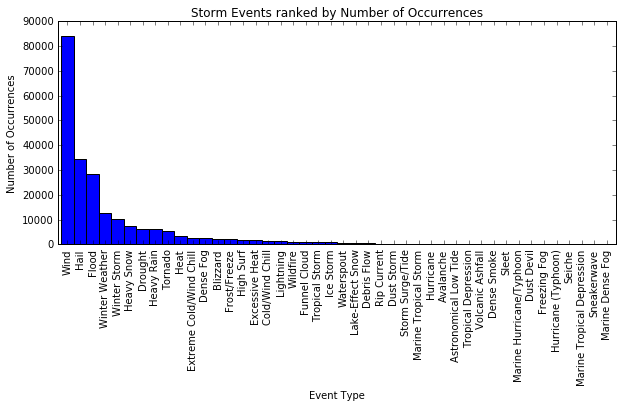

In [40]:
ax1 = df['EVENT_TYPE'].value_counts().plot(kind='bar',width=1,figsize=(10,4))
#ax1 = df['EVENT_TYPE'].value_counts().nlargest(10).plot(kind='bar',width=1,figsize=(10,4)) #Top 10
ax1.set_xlabel("Event Type")
ax1.set_ylabel("Number of Occurrences")
ax1.set_title("Storm Events ranked by Number of Occurrences")

0.4408308625422744

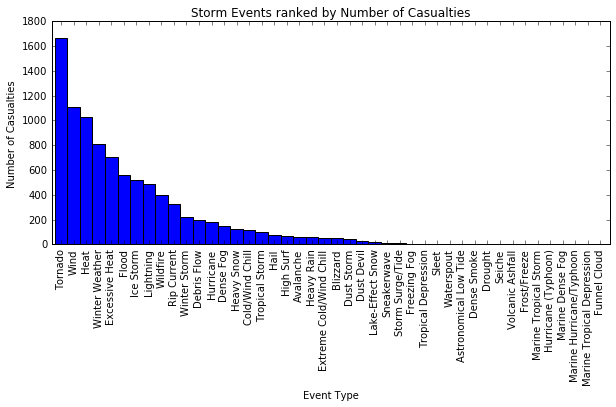

In [41]:
ax2 = df.groupby(['EVENT_TYPE']).sum()['CASUALTIES']
ax2 = ax2.sort_values(ascending=False)
ax2 = ax2.plot(kind='bar',width=1,figsize=(10,4))
ax2.set_xlabel("Event Type")
ax2.set_ylabel("Number of Casualties")
ax2.set_title("Storm Events ranked by Number of Casualties")
#Correlations
ax2a = df['EVENT_TYPE'].value_counts()
ax2b = df.groupby(['EVENT_TYPE']).sum()['CASUALTIES']
ax2a.corr(ax2b)

In [42]:
df.corr()['CASUALTIES']

EPISODE_ID   -0.001220
EVENT_ID     -0.001332
MAGNITUDE     0.020456
TOR_LENGTH    0.215606
TOR_WIDTH     0.163094
CASUALTIES    1.000000
DAMAGES            NaN
DURATION      0.003238
Name: CASUALTIES, dtype: float64

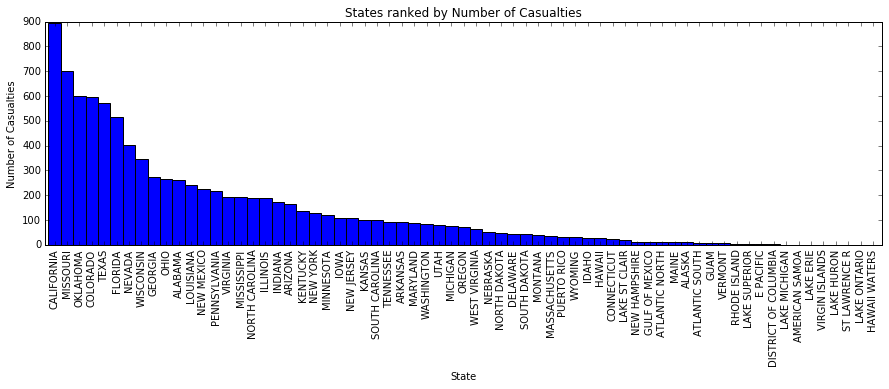

In [43]:
ax3 = df.groupby(['STATE']).sum()['CASUALTIES']
ax3 = ax3.sort_values(ascending=False)
ax3 = ax3.plot(kind="bar",width=1,figsize=(15,4))
ax3.set_xlabel("State")
ax3.set_ylabel("Number of Casualties")
ax3.set_title("States ranked by Number of Casualties")

In [91]:
tor_factors = ['TOR_F_SCALE','TOR_LENGTH','TOR_WIDTH']

df_flood = df[df['EVENT_TYPE']=="Flood"].drop(['EVENT_TYPE','MAGNITUDE','MAGNITUDE_TYPE']+tor_factors,axis=1)
df_wind = df[df['EVENT_TYPE']=="Wind"].drop(['EVENT_TYPE','FLOOD_CAUSE']+tor_factors,axis=1)
df_hail = df[df['EVENT_TYPE']=="Hail"].drop(['EVENT_TYPE','FLOOD_CAUSE','MAGNITUDE_TYPE']+tor_factors,axis=1)
df_tornado = df[df['EVENT_TYPE']=="Tornado"].drop(['EVENT_TYPE','MAGNITUDE','MAGNITUDE_TYPE'],axis=1)
print(df.shape, df_flood.shape, df_wind.shape, df_hail.shape, df_tornado.shape)

((221999, 17), (12816, 11), (0, 12), (34454, 11), (5346, 14))


In [92]:
print(df_wind['MAGNITUDE_TYPE'].unique())
print(df_flood['FLOOD_CAUSE'].unique())

[]
['Heavy Rain' 'Heavy Rain / Snow Melt' 'Heavy Rain / Tropical System'
 'Ice Jam' 'Planned Dam Release' 'Dam / Levee Break'
 'Heavy Rain / Burn Area']


In [96]:
df_flood_fat = df_flood[df_flood['CASUALTIES']>0]
df_wind_fat = df_wind[df_wind['CASUALTIES']>0]
df_hail_fat = df_hail[df_hail['CASUALTIES']>0]
df_tornado_fat = df_tornado[df_tornado['CASUALTIES']>0]
print(df_flood_fat.shape, df_wind_fat.shape, df_hail_fat.shape, df_tornado_fat.shape)
print(pd.unique(df_wind_fat['DURATION']))

((116, 11), (0, 12), (24, 11), (270, 14))
[]


In [94]:
real_df_tor = df_tornado_fat[['TOR_F_SCALE','TOR_LENGTH','TOR_WIDTH','DURATION','CASUALTIES']]
real_df_tor.fillna(0, inplace=True)
print(pd.unique(real_df_tor['DURATION']))
full_x = real_df_tor[['TOR_F_SCALE','TOR_LENGTH','TOR_WIDTH','DURATION']].pipe(
    pd.get_dummies,
    prefix_sep='_', 
    drop_first=True
)
full_y = real_df_tor['CASUALTIES']
x_train, x_test, y_train, y_test = train_test_split(full_x, full_y, train_size=0.8, random_state=4741)

[0. 1.]


In [97]:
model = LinearRegression()
model.fit(x_train,y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", cross_val_score(model, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))

('Training accuracy: ', 0.41299144298399637)
('Cross validation accuracy: ', array([ -5.96649393,  -9.44852684,  -4.67160542,  -6.10568905,
        -6.26905208,  -5.90727474,  -3.88200625,  -2.72959602,
        -5.20763937, -10.39602061]))


In [98]:
model = DecisionTreeRegressor(max_depth=2)
model.fit(x_train,y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", cross_val_score(model, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))

('Training accuracy: ', 0.5159224608682502)
('Cross validation accuracy: ', array([-5.82040895, -9.5743729 , -4.77522488, -5.58816872, -7.64537205,
       -7.19518541, -2.94857119, -2.75354582, -3.78685047, -9.97638834]))


# Experimenting with geographic data

Using land cover data to understand geography of locations, extract land-cover classification from .tif files.

In [47]:
raw_map = rio.open("Data/LandCoverData.tif")

IGBP Classes (1-17 -> 0-16): http://www.eomf.ou.edu/static/IGBP.pdf

Source algorithm for classifications in image: https://eospso.nasa.gov/sites/default/files/atbd/atbd_mod12.pdf

Source data: https://neo.sci.gsfc.nasa.gov/view.php?datasetId=MCD12C1_T1

In [48]:
print(raw_map.name, raw_map.count)
print(raw_map.height, raw_map.width) #number of rows, number of columns
print(raw_map.index(-94.64,30.11)) #takes longitude, then latitude
print(raw_map.bounds)

('Data/LandCoverData.tif', 1)
(1800, 3600)
(598, 853)
BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)


In [49]:
rb = raw_map.read(1)
x,y = raw_map.index(-94.64,30.11) 
print(rb.shape)
rb[x,y]
print(rb.max(), rb.min())

(1800, 3600)
(16, 0)
